In [1]:
import cv2
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Person Detection

I employed a pre-trained TensorFlow model, specifically the efficientnet architecture trained on the COCO dataset, for person detection in my project. This model allows me to detect all objects which I then filter for person. 

In [2]:
import tensorflow as tf

tflite_model_path = "./Model/efficientnet_person_detection.tflite"

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Original Input Details:")
print(input_details)
print("Original Output Details:")
print(output_details)

Original Input Details:
[{'name': 'serving_default_images:0', 'index': 0, 'shape': array([  1, 320, 320,   3]), 'shape_signature': array([  1, 320, 320,   3]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 127), 'quantization_parameters': {'scales': array([0.0078125], dtype=float32), 'zero_points': array([127]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Original Output Details:
[{'name': 'StatefulPartitionedCall:3', 'index': 598, 'shape': array([ 1, 25,  4]), 'shape_signature': array([ 1, 25,  4]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:2', 'index': 599, 'shape': array([ 1, 25]), 'shape_signature': array([ 1, 25]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points'

In [3]:
def predict_and_filter(input_tensor):
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], input_tensor)
    interpreter.invoke()

    output_details = interpreter.get_output_details()

    boxes = interpreter.get_tensor(output_details[0]['index'])
    scores = interpreter.get_tensor(output_details[2]['index'])
    classes = interpreter.get_tensor(output_details[1]['index'])

    class_1_indices = np.where(classes[0] == 0)
    class_1_boxes = boxes[0][class_1_indices]
    class_1_scores = scores[0][class_1_indices]

    confidence_threshold = 0.50
    selected_indices = np.where(class_1_scores > confidence_threshold)
    selected_boxes = class_1_boxes[selected_indices]
    selected_scores = class_1_scores[selected_indices]

    return selected_boxes, selected_scores

In [4]:
def display_image_with_boxes(image, boxes, scores):
    image = image[0]
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    img_height, img_width, _ = image.shape

    for box, score in zip(boxes, scores):
        ymin, xmin, ymax, xmax = box
        ymin = int(ymin * img_height)
        xmin = int(xmin * img_width)
        ymax = int(ymax * img_height)
        xmax = int(xmax * img_width)

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin - 5, f'Score: {score.item():.2f}', color='r')

    plt.show()

In [5]:
def resize_and_pad_image(img, target_size=(64, 64)):
    # this function resizes the image to the target size and pads it with zeros to keep the aspect ratio
    height, width, _ = img.shape

    target_height, target_width = target_size
    aspect_ratio = width / height

    if width == height:
        return cv2.resize(img, target_size)

    if aspect_ratio > 1:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_width = int(target_height * aspect_ratio)
        new_height = target_height

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    top_pad = (target_height - new_height) // 2
    bottom_pad = target_height - new_height - top_pad
    left_pad = (target_width - new_width) // 2
    right_pad = target_width - new_width - left_pad

    padded_img = cv2.copyMakeBorder(resized_img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_img

Frame width: 640
Frame height: 480


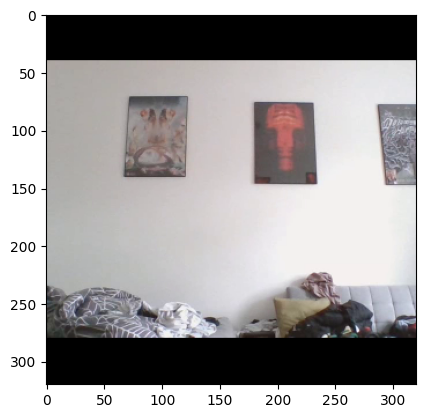

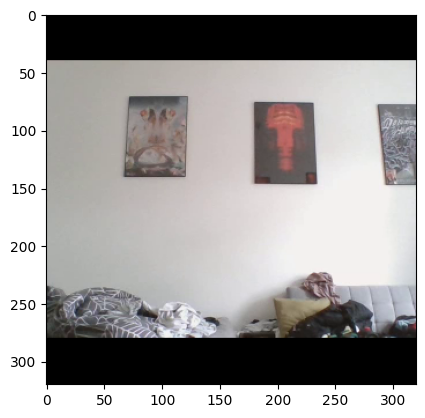

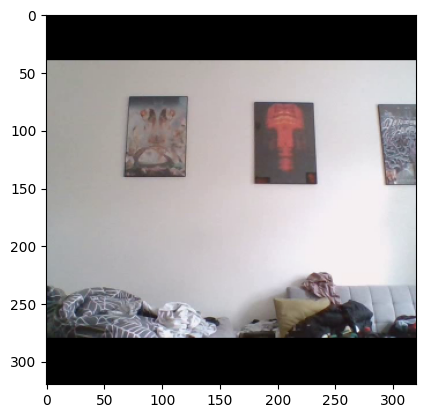

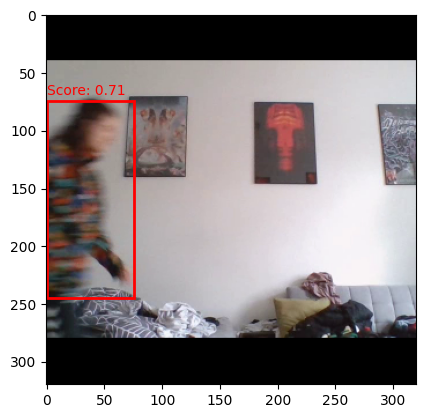

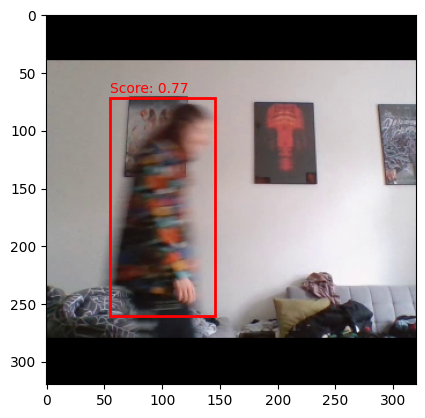

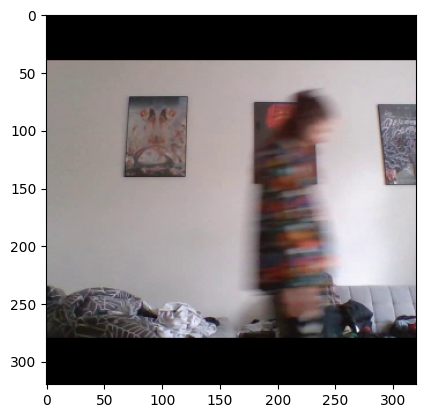

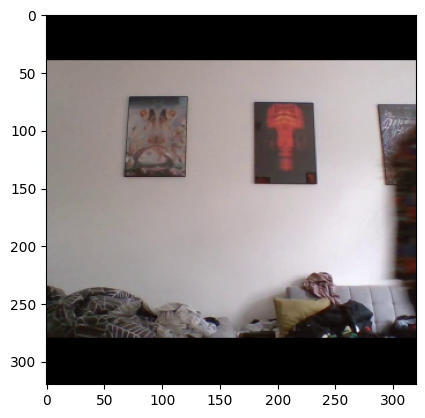

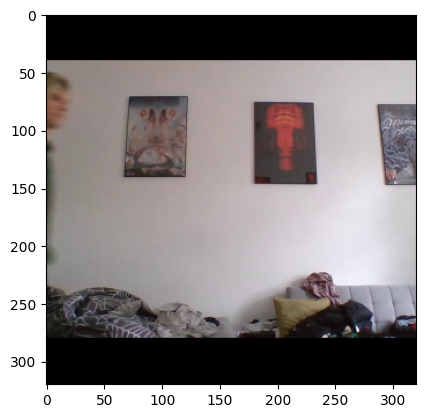

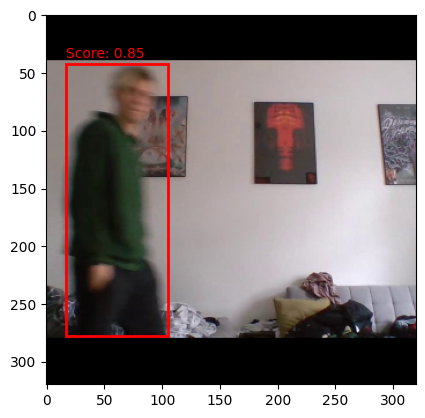

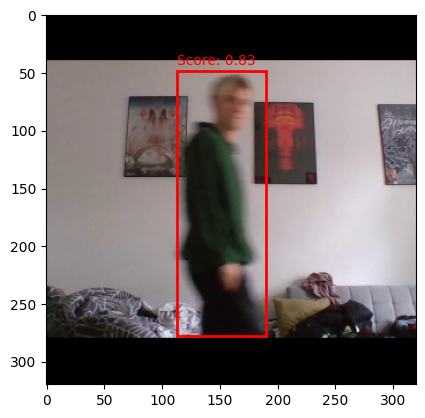

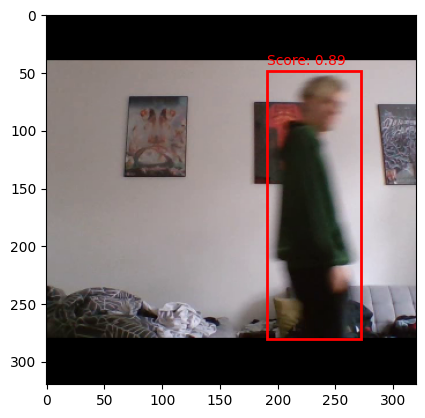

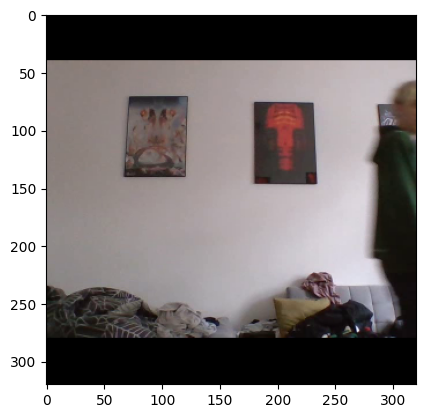

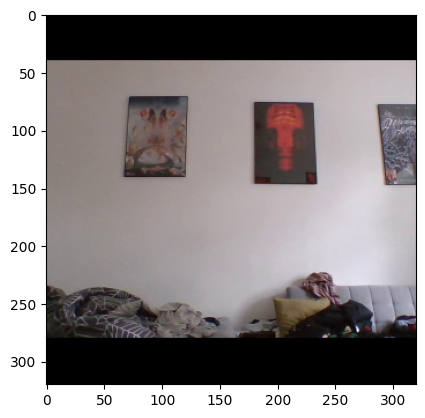

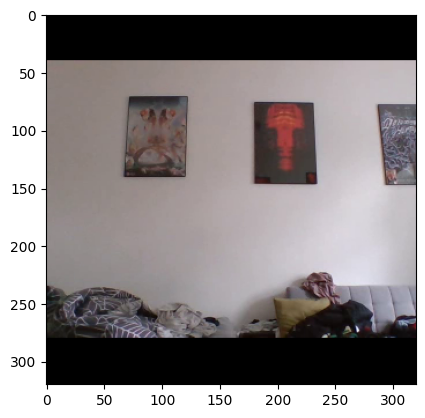

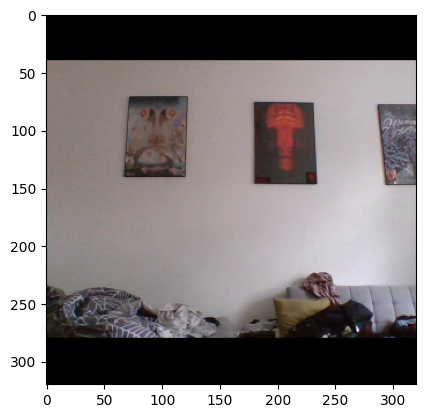

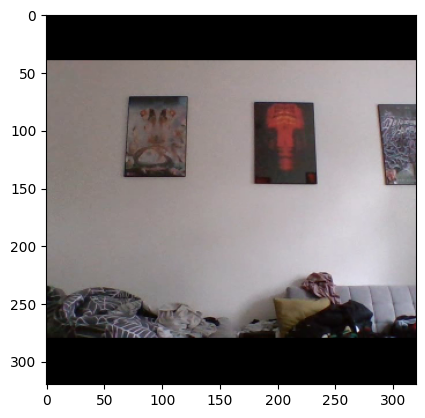

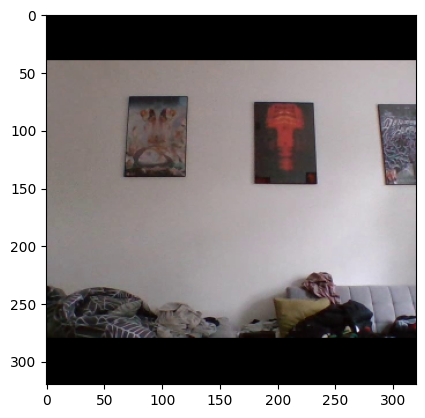

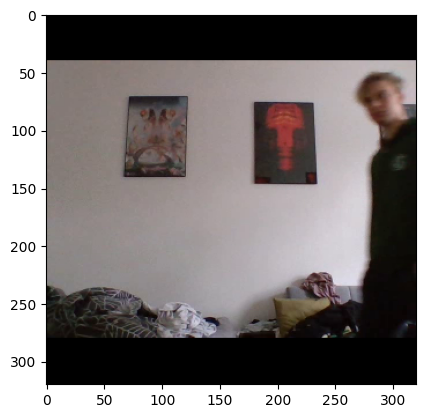

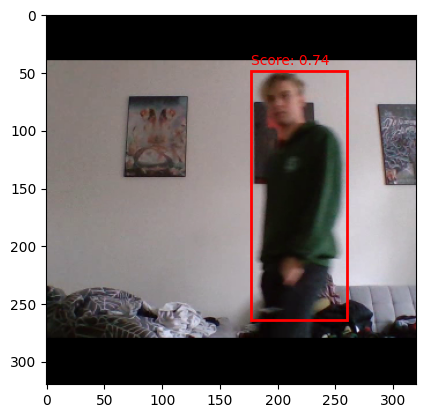

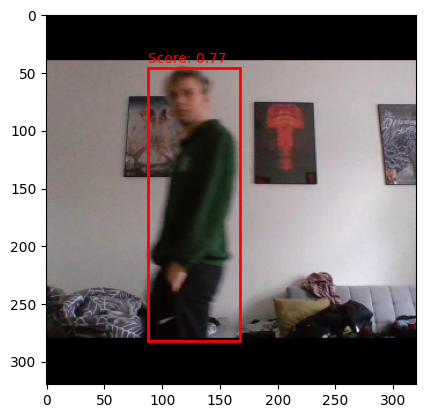

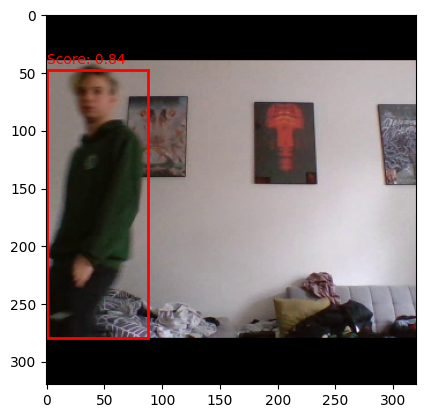

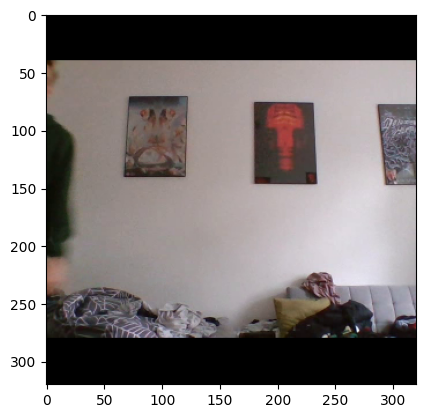

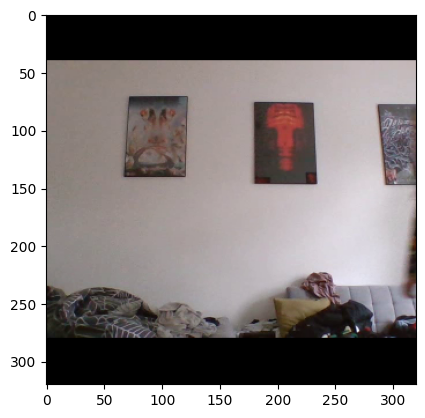

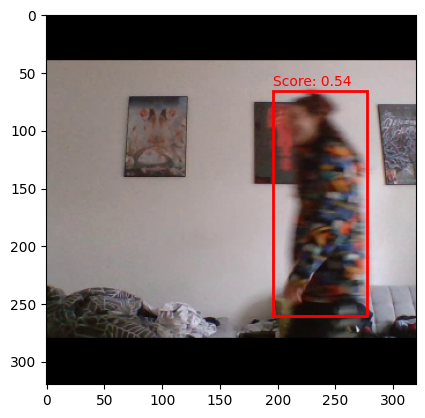

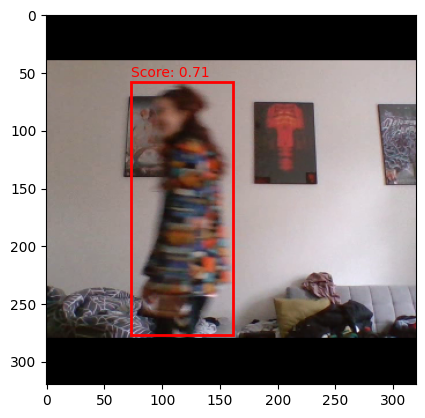

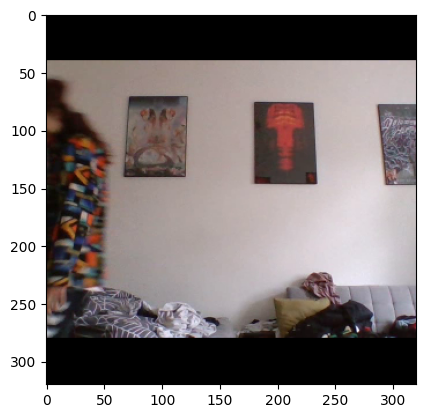

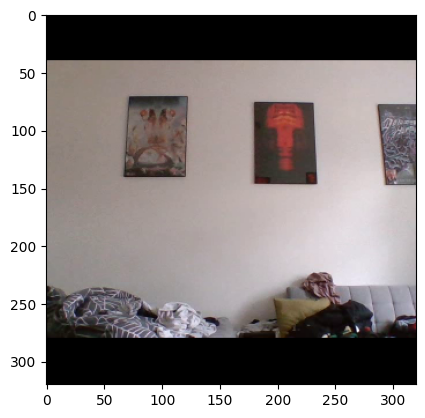

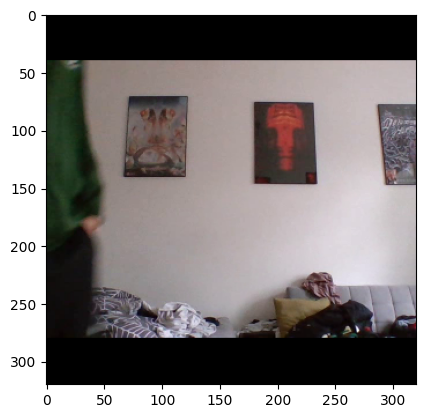

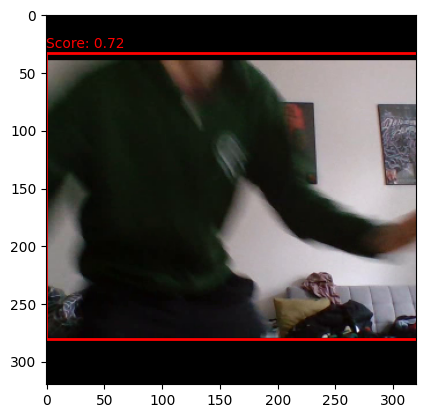

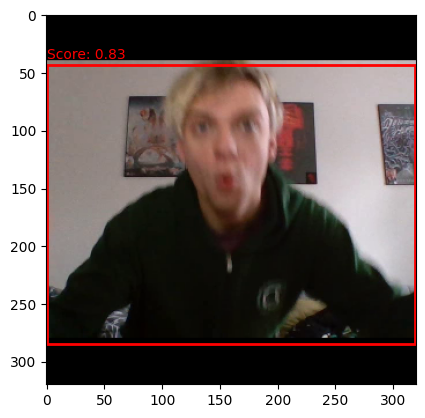

In [7]:
video_path = "./Video/test_video2.mp4"
cap = cv2.VideoCapture(video_path)

output_folder = "detected_persons"
os.makedirs(output_folder, exist_ok=True)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)

print(f"Frame width: {frame_width}")
print(f"Frame height: {frame_height}")

frame_count = 0 
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    if frame_count % 20 == 0:

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        target_size = (320, 320)
        
        input_image = resize_and_pad_image(frame_rgb, target_size)

        input_image = np.expand_dims(input_image.astype(np.uint8), axis=0)


        tf_boxes, tf_scores = predict_and_filter(input_image)
        display_image_with_boxes(input_image, tf_boxes, tf_scores)

    frame_count += 1

cap.release()
cv2.destroyAllWindows()